In [1]:
import pandas as pd
import numpy as np 
import csv

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms
import scipy.stats as stats

from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from applesauce import model_opt, transform_df, model_scoring, cost_benefit_analysis, getList, score_report

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format

### Purpose: Create a model that be able to take in data for a crash and then predict whether or not there was a fatality in the accident.

In [2]:
df = pd.read_csv(r'data/ChicagoCrashes.csv')

In [3]:
df.describe()

,Unnamed: 0,CRASH_DATE_x,OCCUPANT_CNT,POSTED_SPEED_LIMIT,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00
mean,990211.98,2018.06,1.41,28.89,1233.98,2.16,0.25,0.00,0.02,0.13,0.09,2.74,0.00,13.37,4.15,6.72,41.86,-87.68
std,594777.08,1.28,1.41,5.92,699.58,0.56,0.77,0.03,0.19,0.57,0.44,2.01,0.00,5.13,1.96,3.39,0.08,0.06
min,1.00,2015.00,0.00,0.00,111.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,41.64,-87.93
25%,475494.25,2017.00,1.00,30.00,725.00,2.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,10.00,2.00,4.00,41.79,-87.72
50%,965871.50,2018.00,1.00,30.00,1212.00,2.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,14.00,4.00,7.00,41.88,-87.67
75%,1494691.25,2019.00,2.00,30.00,1821.00,2.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,17.00,6.00,10.00,41.92,-87.63
max,2115933.00,2020.00,60.00,99.00,2535.00,15.00,21.00,3.00,6.00,21.00,15.00,61.00,0.00,23.00,7.00,12.00,42.02,-87.52


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567454 entries, 0 to 567453
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     567454 non-null  int64  
 1   CRASH_DATE_x                   567454 non-null  int64  
 2   UNIT_TYPE                      567454 non-null  object 
 3   MAKE                           567454 non-null  object 
 4   MODEL                          567454 non-null  object 
 5   VEHICLE_DEFECT                 567454 non-null  object 
 6   VEHICLE_TYPE                   567454 non-null  object 
 7   VEHICLE_USE                    567454 non-null  object 
 8   MANEUVER                       567454 non-null  object 
 9   OCCUPANT_CNT                   567454 non-null  float64
 10  CRASH_DATE_y                   567454 non-null  object 
 11  POSTED_SPEED_LIMIT             567454 non-null  int64  
 12  TRAFFIC_CONTROL_DEVICE        

In [5]:
yes_no_converter = lambda x: 1 if x>=1 else 0

In [6]:
def transform_df(df): # this will create a binary encoding for fatalities in an accident,
    # 1 for a fatality was present
    # and 0 for no fatality present
    df['INJURIES_FATAL'] = df['INJURIES_FATAL'].apply(yes_no_converter)
    # df['y'] = df['y'].apply(yes_no_converter)
    return df

df = transform_df(df)

### KNN is not good with large or wide datasets, let's choose a different method. 

In [7]:
df.head()

,Unnamed: 0,CRASH_DATE_x,UNIT_TYPE,MAKE,MODEL,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,OCCUPANT_CNT,...,LATITUDE,LONGITUDE,PERSON_ID,PERSON_TYPE,CRASH_DATE,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION
0,577317,2016,DRIVER,"TOYOTA MOTOR COMPANY, LTD.",CAMRY,NONE,PASSENGER,PERSONAL,TURNING RIGHT,1.00,...,41.69,-87.54,O35015,DRIVER,03/18/2016 02:50:00 PM,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
1,1612677,2019,DRIVER,BUICK,ENCLAVE,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.00,...,41.74,-87.60,O804356,DRIVER,12/17/2019 04:04:00 PM,M,SAFETY BELT USED,NOT APPLICABLE,NONE,NO INDICATION OF INJURY
2,547332,2018,DRIVER,CHEVROLET,MALIBU (CHEVELLE),NONE,PASSENGER,PERSONAL,AVOIDING VEHICLES/OBJECTS,1.00,...,41.80,-87.58,O337302,DRIVER,03/05/2018 12:35:00 PM,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
3,756129,2018,DRIVER,HYUNDAI,Accent,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.00,...,41.97,-87.79,O427371,DRIVER,07/07/2018 12:50:00 PM,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
4,95047,2017,DRIVER,CHEVROLET,MONTE CARLO,NONE,PASSENGER,PERSONAL,BACKING,1.00,...,41.77,-87.66,O141732,DRIVER,04/01/2017 11:35:00 AM,M,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY


### Drop object models and objects like date that have too many data points to utilize get_dummies on the data set.

In [8]:
df = df.drop(columns=['Unnamed: 0', 'MAKE', 'MODEL', 'LATITUDE', 'LONGITUDE', 'CRASH_DATE', 'CRASH_DATE_y', 'ALIGNMENT', 'BEAT_OF_OCCURRENCE', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'PERSON_ID', 'CRASH_DATE', 'INJURY_CLASSIFICATION'])

### Dummify the data

In [9]:
df_dummies = pd.get_dummies(df)

### Perform a train test split

In [10]:
df_train, df_valid = train_test_split(df_dummies, test_size=0.60)

In [11]:
display(df_train.info())
display(df_valid.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226981 entries, 215211 to 79012
Columns: 319 entries, CRASH_DATE_x to EJECTION_UNKNOWN
dtypes: float64(1), int64(7), uint8(311)
memory usage: 82.9 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340473 entries, 293302 to 151384
Columns: 319 entries, CRASH_DATE_x to EJECTION_UNKNOWN
dtypes: float64(1), int64(7), uint8(311)
memory usage: 124.4 MB


None

### Create training variables for the training data and the test data

In [12]:
df_train_X = df_train.drop(columns='INJURIES_FATAL')
df_train_y = df_train.loc[:,'INJURIES_FATAL']

X = df_train_X 
y = df_train_y

data_full = df_train.groupby(by='INJURIES_FATAL').sum()
data_full.to_csv('crash_data.csv')
display(X.head())
display(y.head())

,CRASH_DATE_x,OCCUPANT_CNT,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,UNIT_TYPE_DISABLED VEHICLE,UNIT_TYPE_DRIVER,UNIT_TYPE_DRIVERLESS,...,"AIRBAG_DEPLOYED_DEPLOYED, FRONT","AIRBAG_DEPLOYED_DEPLOYED, SIDE",AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_DID NOT DEPLOY,AIRBAG_DEPLOYED_NOT APPLICABLE,EJECTION_NONE,EJECTION_PARTIALLY EJECTED,EJECTION_TOTALLY EJECTED,EJECTION_TRAPPED/EXTRICATED,EJECTION_UNKNOWN
215211,2019,2.00,30,3,11,1,12,0,1,0,...,0,0,0,1,0,1,0,0,0,0
53657,2019,1.00,35,3,21,2,10,0,1,0,...,0,0,0,1,0,1,0,0,0,0
43090,2017,1.00,30,2,7,4,8,0,1,0,...,0,0,0,1,0,1,0,0,0,0
22369,2019,2.00,30,2,10,1,10,0,1,0,...,0,0,1,0,0,1,0,0,0,0
258984,2018,5.00,35,3,8,3,7,0,1,0,...,0,0,0,1,0,1,0,0,0,0


215211    0
53657     0
43090     0
22369     0
258984    0
Name: INJURIES_FATAL, dtype: int64

In [13]:
df_valid_X = df_valid.drop(columns='INJURIES_FATAL')
df_valid_y = df_valid.loc[:,'INJURIES_FATAL']

X_valid = df_valid_X
y_valid = df_valid_y

display(df_valid_X.head())
display(df_valid_y.head())

,CRASH_DATE_x,OCCUPANT_CNT,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,UNIT_TYPE_DISABLED VEHICLE,UNIT_TYPE_DRIVER,UNIT_TYPE_DRIVERLESS,...,"AIRBAG_DEPLOYED_DEPLOYED, FRONT","AIRBAG_DEPLOYED_DEPLOYED, SIDE",AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_DID NOT DEPLOY,AIRBAG_DEPLOYED_NOT APPLICABLE,EJECTION_NONE,EJECTION_PARTIALLY EJECTED,EJECTION_TOTALLY EJECTED,EJECTION_TRAPPED/EXTRICATED,EJECTION_UNKNOWN
293302,2017,2.00,45,3,9,3,5,0,1,0,...,0,1,0,0,0,1,0,0,0,0
159985,2018,1.00,30,2,18,2,8,0,1,0,...,0,0,0,1,0,1,0,0,0,0
357479,2016,3.00,30,2,7,3,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
376180,2017,0.00,30,2,21,3,2,0,0,0,...,0,0,1,0,0,1,0,0,0,0
54523,2019,3.00,30,2,18,5,3,0,1,0,...,0,0,0,1,0,1,0,0,0,0


293302    0
159985    0
357479    0
376180    0
54523     0
Name: INJURIES_FATAL, dtype: int64

In [14]:
X.shape, y.shape, X_valid.shape, y_valid.shape

((226981, 318), (226981,), (340473, 318), (340473,))

In [15]:
df_train['INJURIES_FATAL'].value_counts(normalize=True)

0   1.00
1   0.00
Name: INJURIES_FATAL, dtype: float64

In [16]:
df_train.head()

,CRASH_DATE_x,OCCUPANT_CNT,POSTED_SPEED_LIMIT,NUM_UNITS,INJURIES_FATAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,UNIT_TYPE_DISABLED VEHICLE,UNIT_TYPE_DRIVER,...,"AIRBAG_DEPLOYED_DEPLOYED, FRONT","AIRBAG_DEPLOYED_DEPLOYED, SIDE",AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_DID NOT DEPLOY,AIRBAG_DEPLOYED_NOT APPLICABLE,EJECTION_NONE,EJECTION_PARTIALLY EJECTED,EJECTION_TOTALLY EJECTED,EJECTION_TRAPPED/EXTRICATED,EJECTION_UNKNOWN
215211,2019,2.00,30,3,0,11,1,12,0,1,...,0,0,0,1,0,1,0,0,0,0
53657,2019,1.00,35,3,0,21,2,10,0,1,...,0,0,0,1,0,1,0,0,0,0
43090,2017,1.00,30,2,0,7,4,8,0,1,...,0,0,0,1,0,1,0,0,0,0
22369,2019,2.00,30,2,0,10,1,10,0,1,...,0,0,1,0,0,1,0,0,0,0
258984,2018,5.00,35,3,0,8,3,7,0,1,...,0,0,0,1,0,1,0,0,0,0


### Manually sample data based on target class in order to deal with large class imbalance (~270 fatal accidents to over 560,000 non fatal accidents

In [17]:
from sklearn.utils import resample

In [18]:
df_majority = df_train.loc[df['INJURIES_FATAL']==0]
df_minority = df_train.loc[df['INJURIES_FATAL']==1]

In [19]:
df_minority.shape

(108, 319)

In [20]:
df_majority.shape

(226873, 319)

In [21]:
df_min_sample = resample(df_minority, replace=True, n_samples=1000, random_state=42)

In [22]:
df_maj_sample = resample(df_majority, replace=True, n_samples=5000, random_state=42)

In [23]:
num_cols = df_train.drop(columns=['INJURIES_FATAL']).columns
num_cols

Index(['CRASH_DATE_x', 'OCCUPANT_CNT', 'POSTED_SPEED_LIMIT', 'NUM_UNITS',
       'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'UNIT_TYPE_DISABLED VEHICLE', 'UNIT_TYPE_DRIVER',
       'UNIT_TYPE_DRIVERLESS',
       ...
       'AIRBAG_DEPLOYED_DEPLOYED, FRONT', 'AIRBAG_DEPLOYED_DEPLOYED, SIDE',
       'AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN', 'AIRBAG_DEPLOYED_DID NOT DEPLOY',
       'AIRBAG_DEPLOYED_NOT APPLICABLE', 'EJECTION_NONE',
       'EJECTION_PARTIALLY EJECTED', 'EJECTION_TOTALLY EJECTED',
       'EJECTION_TRAPPED/EXTRICATED', 'EJECTION_UNKNOWN'],
      dtype='object', length=318)

### Create upsampled data and smote for full feature set

In [24]:
df_train_upsampled = pd.concat([df_min_sample, df_maj_sample], axis=0)
df_train_upsampled.shape

(6000, 319)

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
X_train, y_train = df_train_upsampled[num_cols], df_train_upsampled['INJURIES_FATAL']

In [27]:
smote=SMOTE()

In [28]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote.head()

,CRASH_DATE_x,OCCUPANT_CNT,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,UNIT_TYPE_DISABLED VEHICLE,UNIT_TYPE_DRIVER,UNIT_TYPE_DRIVERLESS,...,"AIRBAG_DEPLOYED_DEPLOYED, FRONT","AIRBAG_DEPLOYED_DEPLOYED, SIDE",AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_DID NOT DEPLOY,AIRBAG_DEPLOYED_NOT APPLICABLE,EJECTION_NONE,EJECTION_PARTIALLY EJECTED,EJECTION_TOTALLY EJECTED,EJECTION_TRAPPED/EXTRICATED,EJECTION_UNKNOWN
0,2017,2.00,30,2,2,1,5,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,2020,1.00,30,7,22,6,7,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,2017,1.00,30,2,9,1,2,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,2019,3.00,15,1,6,7,9,0,1,0,...,0,0,0,1,0,1,0,0,0,0
4,2018,1.00,35,2,3,4,9,0,1,0,...,0,0,0,1,0,1,0,0,0,0


### Run a Random Forest model, fit train and test on SMOTE'd data

In [29]:
clf = RandomForestClassifier(max_depth=5, min_samples_leaf=0.1, n_estimators=30)

In [30]:
clf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, min_samples_leaf=0.1, n_estimators=30)

In [31]:
clf.score(X_train, y_train)

0.8121666666666667

In [32]:
y_valid_pred = clf.predict(X_valid)

In [33]:
X_all, y_all = df_train[num_cols], df_train['INJURIES_FATAL']

In [34]:
clf.score(X_all, y_all)

0.7655486582577397

In [35]:
print(classification_report(y_valid, clf.predict(X_valid[num_cols])))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87    340314
           1       0.00      0.99      0.00       159

    accuracy                           0.77    340473
   macro avg       0.50      0.88      0.44    340473
weighted avg       1.00      0.77      0.87    340473



Accuracy Score:  0.7654821380843708
Precision Score:  0.001962450938726532
Recall Score:  0.9874213836477987
F1 Score:  0.003917116802435099


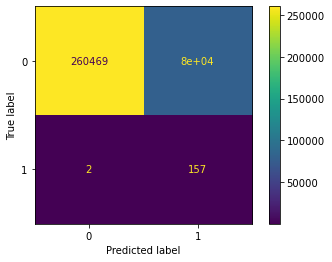

In [36]:
score_report(y_valid, y_valid_pred)
plot_confusion_matrix(clf, X_valid[num_cols], y_valid)
plt.show()

#### Confusion matrix shows that the model is giving over 79000 false positive indications of death, but is classifying a majority of actual deaths correctly. 

In [37]:
print('''
      This is the total number of accidents with a fatality 
      divided by the total number of accidents, expressed as 
      a percent: ''',(df['INJURIES_FATAL'].sum()/df['INJURIES_FATAL'].count()*100))
print('''
      This is the total number of accidents with a fatality: ''',df['INJURIES_FATAL'].sum())
print('''
      This is the total number of accidents: ''', df['INJURIES_FATAL'].count())


      This is the total number of accidents with a fatality 
      divided by the total number of accidents, expressed as 
      a percent:  0.0470522720784416

      This is the total number of accidents with a fatality:  267

      This is the total number of accidents:  567454


### Use select k best to limit number of features

In [38]:
selector = SelectKBest(score_func=chi2, k=10)

In [39]:
sel = selector.fit(X_train_smote, y_train_smote)

In [40]:
dfscores = sel.scores_
dfcols = X.columns

featscore = {}
for num in list(range(len(dfcols))):
    featscore[dfcols[num]] = round(dfscores[num], 2)
    
top_75 = {}
for item in sorted(featscore.items(), key=lambda x: x[1], reverse=True)[:75]:
    top_75[item[0]] = item[1]

In [41]:
top_75 # most impactful features indicating a fatality is likely

{'NUM_UNITS': 1348.61,
 'OCCUPANT_CNT': 356.12,
 'CRASH_MONTH': 218.6,
 'POSTED_SPEED_LIMIT': 118.67,
 'CRASH_DAY_OF_WEEK': 81.38,
 'CRASH_DATE_x': 0.43,
 'UNIT_TYPE_DISABLED VEHICLE': nan,
 'UNIT_TYPE_DRIVERLESS': 171.37,
 'CRASH_HOUR': 112.3,
 'UNIT_TYPE_NON-CONTACT VEHICLE': nan,
 'UNIT_TYPE_PARKED': 38.56,
 'VEHICLE_DEFECT_BRAKES': 11.13,
 'VEHICLE_DEFECT_CARGO': nan,
 'VEHICLE_DEFECT_ENGINE/MOTOR': nan,
 'VEHICLE_DEFECT_EXHAUST': nan,
 'VEHICLE_DEFECT_FUEL SYSTEM': nan,
 'VEHICLE_DEFECT_LIGHTS': nan,
 'VEHICLE_DEFECT_RESTRAINT SYSTEM': nan,
 'VEHICLE_DEFECT_SIGNALS': nan,
 'VEHICLE_DEFECT_SUSPENSION': nan,
 'VEHICLE_DEFECT_TRAILER COUPLING': nan,
 'VEHICLE_TYPE_3-WHEELED MOTORCYCLE (2 REAR WHEELS)': nan,
 'VEHICLE_TYPE_BUS OVER 15 PASS.': 21.35,
 'VEHICLE_TYPE_FARM EQUIPMENT': nan,
 'VEHICLE_TYPE_MOPED OR MOTORIZED BICYCLE': nan,
 'VEHICLE_TYPE_MOTORCYCLE (OVER 150CC)': 44.8,
 'UNIT_TYPE_DRIVER': 21.1,
 'VEHICLE_TYPE_BUS UP TO 15 PASS.': 16.0,
 'VEHICLE_DEFECT_STEERING': 5.0,
 'VE

In [42]:
# def getList(dict):
#     return dict.keys()

new_features = getList(top_75)

In [43]:
top75_features = list(new_features)
print(top75_features)

['NUM_UNITS', 'OCCUPANT_CNT', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT', 'CRASH_DAY_OF_WEEK', 'CRASH_DATE_x', 'UNIT_TYPE_DISABLED VEHICLE', 'UNIT_TYPE_DRIVERLESS', 'CRASH_HOUR', 'UNIT_TYPE_NON-CONTACT VEHICLE', 'UNIT_TYPE_PARKED', 'VEHICLE_DEFECT_BRAKES', 'VEHICLE_DEFECT_CARGO', 'VEHICLE_DEFECT_ENGINE/MOTOR', 'VEHICLE_DEFECT_EXHAUST', 'VEHICLE_DEFECT_FUEL SYSTEM', 'VEHICLE_DEFECT_LIGHTS', 'VEHICLE_DEFECT_RESTRAINT SYSTEM', 'VEHICLE_DEFECT_SIGNALS', 'VEHICLE_DEFECT_SUSPENSION', 'VEHICLE_DEFECT_TRAILER COUPLING', 'VEHICLE_TYPE_3-WHEELED MOTORCYCLE (2 REAR WHEELS)', 'VEHICLE_TYPE_BUS OVER 15 PASS.', 'VEHICLE_TYPE_FARM EQUIPMENT', 'VEHICLE_TYPE_MOPED OR MOTORIZED BICYCLE', 'VEHICLE_TYPE_MOTORCYCLE (OVER 150CC)', 'UNIT_TYPE_DRIVER', 'VEHICLE_TYPE_BUS UP TO 15 PASS.', 'VEHICLE_DEFECT_STEERING', 'VEHICLE_TYPE_OTHER', 'VEHICLE_TYPE_OTHER VEHICLE WITH TRAILER', 'VEHICLE_DEFECT_WHEELS', 'VEHICLE_DEFECT_TIRES', 'VEHICLE_TYPE_MOTOR DRIVEN CYCLE', 'VEHICLE_DEFECT_WINDOWS', 'VEHICLE_TYPE_ALL-TERRAIN VEHIC

### Create SelectKBest features variable

In [44]:
feature_list = top75_features
X2 = X_train_smote.loc[:,feature_list]
y2 = y_train_smote
# df_valid_X2 = df_valid[feature_list]
df_valid_X2 = df_valid_X.loc[:,feature_list]

### Optimize the model using a for loop and model type


In [45]:
ran_for = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
gau_NB = GaussianNB()

models = [ran_for, ada_clf, gb_clf, gau_NB]

Accuracy Score:  0.9997180393158929
Precision Score:  0.8
Recall Score:  0.5283018867924528
F1 Score:  0.6363636363636364
RandomForestClassifier()   0.9997180393158929


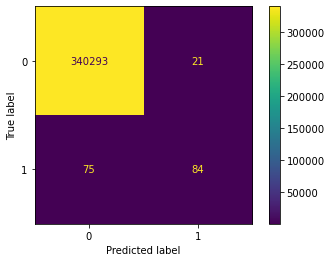

Accuracy Score:  0.9435109391934162
Precision Score:  0.006774927596193628
Recall Score:  0.8238993710691824
F1 Score:  0.013439343421390101
AdaBoostClassifier()   0.9435109391934162


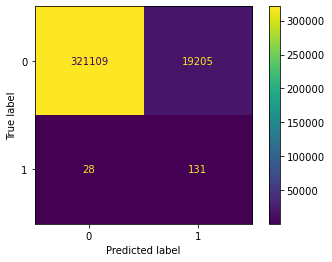

Accuracy Score:  0.9474965709468885
Precision Score:  0.007395873880887505
Recall Score:  0.8364779874213837
F1 Score:  0.014662110020945873
GradientBoostingClassifier()   0.9474965709468885


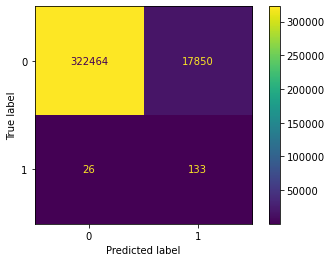

Accuracy Score:  0.8315461137887585
Precision Score:  0.002297290241737587
Recall Score:  0.8301886792452831
F1 Score:  0.004581901489117984
GaussianNB()   0.8315461137887585


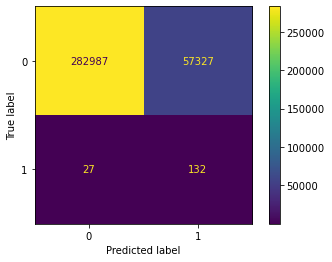

In [46]:
model_opt(models, X_train_smote, y_train_smote, X_valid, y_valid) # full dataset
# of all models run, the base RFC tree is the best most accurate and 
# precise model for predicting whether or not a death occurred

In [47]:
def single_model_opt(model, x, y, xtest, ytest):
    pipe = Pipeline(steps=[('model', model)])
    fit = pipe.fit(x, y)
    ypred = model.predict(xtest)
    score_report(ytest, ypred)
    print(model," ", fit.score(xtest, ytest))
    plot_confusion_matrix(model, xtest, ytest, values_format='1')
    plt.show()
    pass

Accuracy Score:  0.9997297876777307
Precision Score:  0.819047619047619
Recall Score:  0.5408805031446541
F1 Score:  0.6515151515151515
RandomForestClassifier()   0.9997297876777307


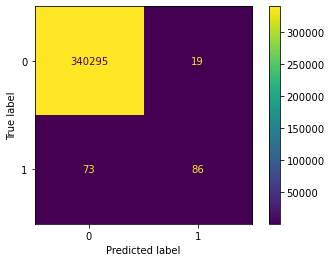

In [48]:
single_model_opt(ran_for, X_train_smote, y_train_smote, X_valid, y_valid)

### This model is the the most accurate and has a reasonable recall score. There are less than 120 false positives out of over 340,000 negatives to classify. 

### Additionally, recall of over 60% while is excellent in combination with overall accuracy.

### Out of the above models, Random Forest performs the best. Let's see if after applying feature selection if it continues to perform better than the other models. 

Accuracy Score:  0.9986078191222212
Precision Score:  0.17255717255717257
Recall Score:  0.5220125786163522
F1 Score:  0.259375
RandomForestClassifier()   0.9986078191222212


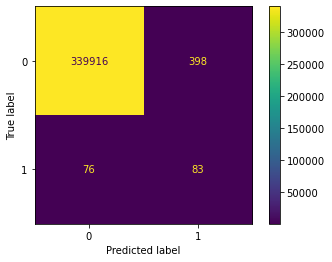

Accuracy Score:  0.8619831822200292
Precision Score:  0.002337838986653065
Recall Score:  0.6918238993710691
F1 Score:  0.004659930948295948
AdaBoostClassifier()   0.8619831822200292


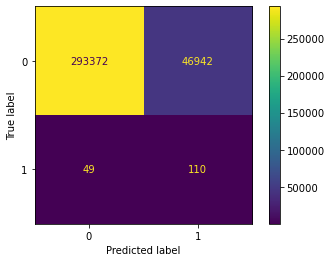

Accuracy Score:  0.9269868682685558
Precision Score:  0.0039762229897983776
Recall Score:  0.6226415094339622
F1 Score:  0.007901983477670911
GradientBoostingClassifier()   0.9269868682685558


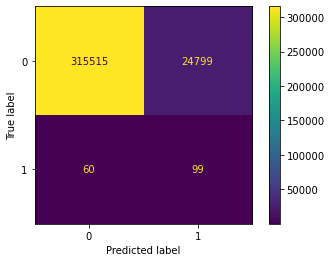

Accuracy Score:  0.09217177279843042
Precision Score:  0.0004753804660668896
Recall Score:  0.9245283018867925
F1 Score:  0.0009502723144302407
GaussianNB()   0.09217177279843042


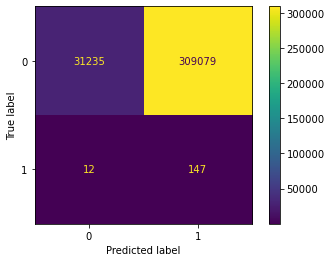

In [49]:
model_opt(models, X2, y2, df_valid_X2, y_valid) # this is the reduced feature set

# Random Forest performed worse with a reduced set of features. 


In [50]:
# GridsearchCV and improving the full set Random Forest classifier with full set of features

### Tuning Hyper-parameters for a random forest model 

In [51]:
# create single item lists for input to model_opt and also gridsearchCV. 
selected_model = [ran_for]

In [52]:
for model in selected_model:
    print(model.get_params().keys())

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


In [53]:
# pipe_random = Pipeline([
#     ('select', SelectKBest()),
#     ('model', ran_for)])
# pipe_bayes = Pipeline([
#     ('select', SelectKBest()),
#     ('model', cat_bayes)])

In [54]:
ran_for = RandomForestClassifier()
cat_bayes = CategoricalNB()
param_random = {
    "max_depth": [3,5,7,11,15],
    "n_estimators": range(5,50,5),
    "max_leaf_nodes": range(3,10,2),
    "max_features": range(5,50,5)
    }

In [55]:
# need to improve on overall precision, so scoring for both models will be precision
gsforest = GridSearchCV(estimator=ran_for, param_grid=param_random, cv=5, scoring='precision', 
                    verbose=1, n_jobs=6)

In [56]:
# initial SMOTED training set
gsforest.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   14.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   27.0s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   46.2s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 8100 out of 8100 | elapsed:  6.7min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'max_depth': [3, 5, 7, 11, 15],
                         'max_features': range(5, 50, 5),
                         'max_leaf_nodes': range(3, 10, 2),
                         'n_estimators': range(5, 50, 5)},
             scoring='precision', verbose=1)

In [57]:
y_preds = gsforest.predict(X_valid)

In [58]:
sum(y_preds)

39407

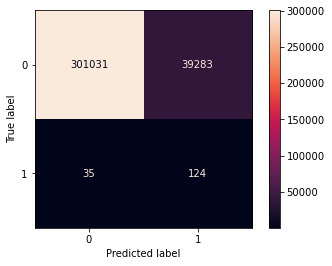

In [59]:
plot_confusion_matrix(gsforest, X_valid, y_valid, cmap='rocket', values_format='1')
plt.show()

In [60]:
gsforest_f1 = gsforest.best_estimator_
gsforest_f1

RandomForestClassifier(max_depth=7, max_features=5, max_leaf_nodes=9,
                       n_estimators=35)

In [61]:
print(gsforest_f1.score(X_train_smote, y_train_smote))
print(gsforest_f1.score(X_valid, y_valid)) # model is not overfit

0.8969
0.8845194773153818


In [62]:
gsforest_f1.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=7, max_features=5, max_leaf_nodes=9,
                       n_estimators=35)

In [63]:
y_preds = gsforest_f1.predict(X_valid)
sum(y_preds)

40697

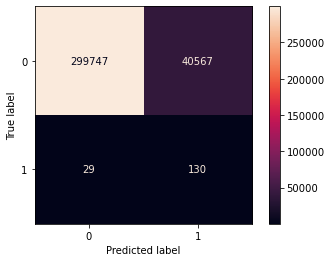

In [64]:
plot_confusion_matrix(gsforest_f1, X_valid, y_valid, cmap='rocket', values_format='1')
plt.show()

In [65]:
gsforest.fit(X2, y2)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   11.8s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   31.6s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2464 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3564 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4856 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 5606 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 6456 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 7406 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 8100 out of 8100 | elapsed:  6.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'max_depth': [3, 5, 7, 11, 15],
                         'max_features': range(5, 50, 5),
                         'max_leaf_nodes': range(3, 10, 2),
                         'n_estimators': range(5, 50, 5)},
             scoring='precision', verbose=1)

In [66]:
gsforest.best_estimator_

RandomForestClassifier(max_depth=5, max_features=15, max_leaf_nodes=9,
                       n_estimators=45)

In [67]:
gsforest_high_precision_partial = gsforest.best_estimator_
gsforest_high_precision_partial

RandomForestClassifier(max_depth=5, max_features=15, max_leaf_nodes=9,
                       n_estimators=45)

In [68]:
gsforest_high_precision_partial.predict(X2)

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [69]:
y_preds2 = gsforest_high_precision_partial.predict(X2)

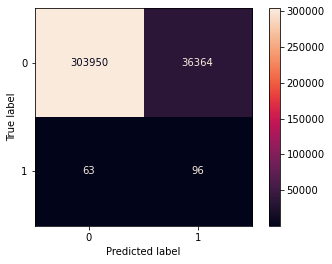

In [70]:
plot_confusion_matrix(gsforest_high_precision_partial, df_valid_X2, y_valid, cmap='rocket', values_format='1')
plt.show() 

In [71]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_features=40)
clf.fit(X_train_smote, y_train_smote)
y_preds_clf = clf.predict(X_valid)

Accuracy Score:  0.9904955752732229
Precision Score:  0.02617801047120419
Recall Score:  0.5345911949685535
F1 Score:  0.049911920140927775
DecisionTreeClassifier(max_features=40, random_state=1608637542)   0.9904955752732229


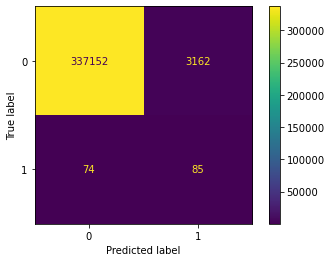

Accuracy Score:  0.9875379251805576
Precision Score:  0.01998119417019276
Recall Score:  0.5345911949685535
F1 Score:  0.038522547020167684
DecisionTreeClassifier(max_features=40, random_state=1273642419)   0.9875379251805576


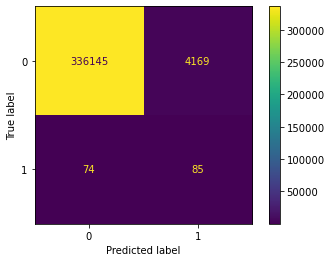

Accuracy Score:  0.9878257600455836
Precision Score:  0.02045235803657363
Recall Score:  0.5345911949685535
F1 Score:  0.03939745075318656
DecisionTreeClassifier(max_features=40, random_state=1935803228)   0.9878257600455836


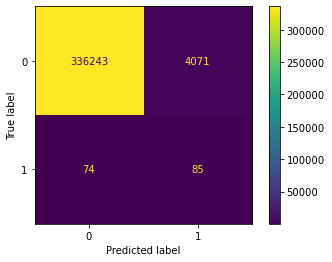

Accuracy Score:  0.986997500536019
Precision Score:  0.017849073655671035
Recall Score:  0.4968553459119497
F1 Score:  0.03446019629225736
DecisionTreeClassifier(max_features=40, random_state=787846414)   0.986997500536019


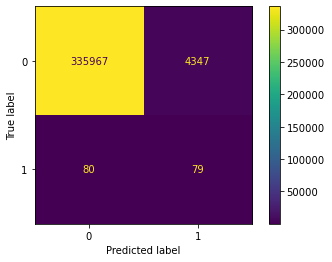

Accuracy Score:  0.9888331820731747
Precision Score:  0.023292331850300968
Recall Score:  0.559748427672956
F1 Score:  0.044723618090452257
DecisionTreeClassifier(max_features=40, random_state=996406378)   0.9888331820731747


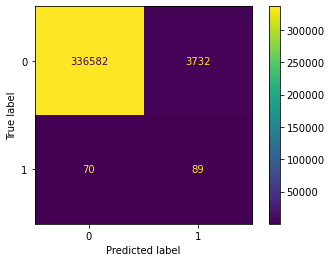

Accuracy Score:  0.990974321018113
Precision Score:  0.022920759659463
Recall Score:  0.44025157232704404
F1 Score:  0.04357298474945534
DecisionTreeClassifier(max_features=40, random_state=1201263687)   0.990974321018113


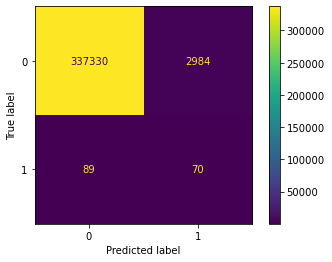

Accuracy Score:  0.989822981558009
Precision Score:  0.02308136180034622
Recall Score:  0.5031446540880503
F1 Score:  0.044137931034482755
DecisionTreeClassifier(max_features=40, random_state=423734972)   0.989822981558009


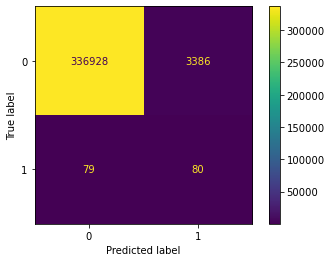

Accuracy Score:  0.9913032751495713
Precision Score:  0.02668918918918919
Recall Score:  0.4968553459119497
F1 Score:  0.05065726194293044
DecisionTreeClassifier(max_features=40, random_state=415968276)   0.9913032751495713


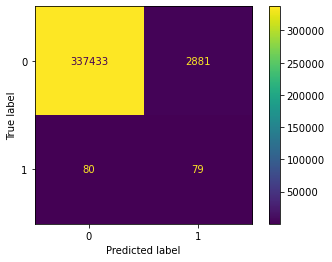

Accuracy Score:  0.9896555674018204
Precision Score:  0.0224368077250781
Recall Score:  0.4968553459119497
F1 Score:  0.042934782608695654
DecisionTreeClassifier(max_features=40, random_state=670094950)   0.9896555674018204


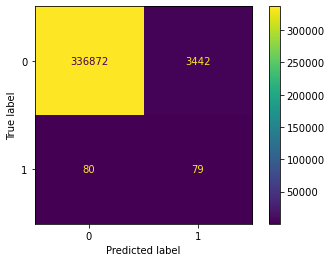

Accuracy Score:  0.9872677128582883
Precision Score:  0.019337016574585635
Recall Score:  0.5283018867924528
F1 Score:  0.037308461025982675
DecisionTreeClassifier(max_features=40, random_state=1914837113)   0.9872677128582883


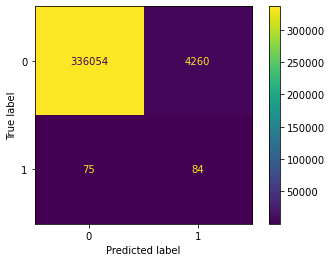

Accuracy Score:  0.9858197272617799
Precision Score:  0.019353510397364628
Recall Score:  0.5911949685534591
F1 Score:  0.037480063795853266
DecisionTreeClassifier(max_features=40, random_state=669991378)   0.9858197272617799


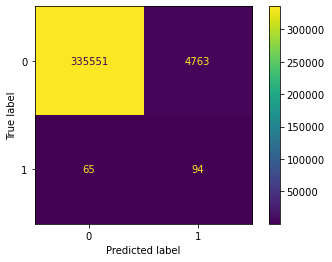

Accuracy Score:  0.9914148845870304
Precision Score:  0.027682843472317156
Recall Score:  0.5094339622641509
F1 Score:  0.05251215559157212
DecisionTreeClassifier(max_features=40, random_state=429389014)   0.9914148845870304


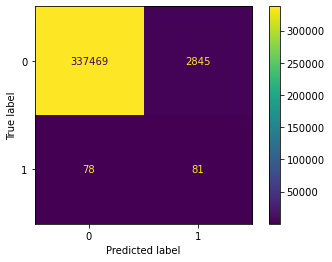

Accuracy Score:  0.9877640811459352
Precision Score:  0.021951801479360534
Recall Score:  0.5786163522012578
F1 Score:  0.042298850574712644
DecisionTreeClassifier(max_features=40, random_state=249467210)   0.9877640811459352


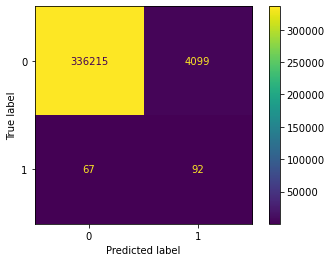

Accuracy Score:  0.988900735153742
Precision Score:  0.022175290390707498
Recall Score:  0.5283018867924528
F1 Score:  0.04256397263744616
DecisionTreeClassifier(max_features=40, random_state=1972458954)   0.988900735153742


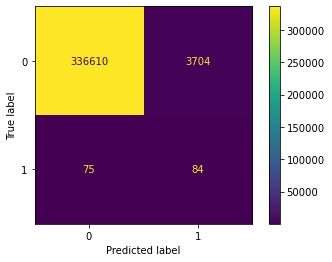

Accuracy Score:  0.9910712450032748
Precision Score:  0.028169014084507043
Recall Score:  0.5408805031446541
F1 Score:  0.053549190535491904
DecisionTreeClassifier(max_features=40, random_state=1572714583)   0.9910712450032748


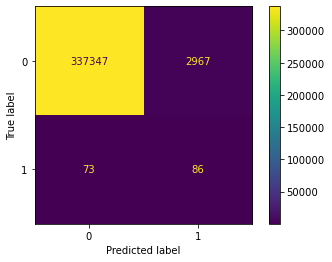

Accuracy Score:  0.9907569763241139
Precision Score:  0.02631578947368421
Recall Score:  0.5220125786163522
F1 Score:  0.05010564443102928
DecisionTreeClassifier(max_features=40, random_state=1433267572)   0.9907569763241139


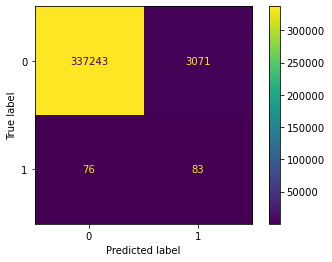

Accuracy Score:  0.9871972226872615
Precision Score:  0.021422060164083864
Recall Score:  0.5911949685534591
F1 Score:  0.04134594237959094
DecisionTreeClassifier(max_features=40, random_state=434285667)   0.9871972226872615


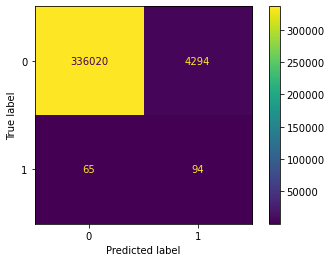

Accuracy Score:  0.9889712253247688
Precision Score:  0.02155401809473124
Recall Score:  0.5094339622641509
F1 Score:  0.04135818228235895
DecisionTreeClassifier(max_features=40, random_state=613608295)   0.9889712253247688


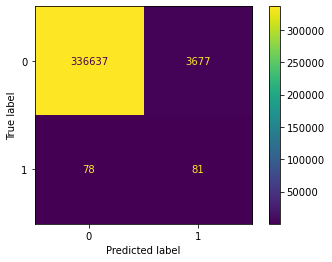

Accuracy Score:  0.9864600129819399
Precision Score:  0.01922661481961547
Recall Score:  0.559748427672956
F1 Score:  0.03717627401837928
DecisionTreeClassifier(max_features=40, random_state=893664919)   0.9864600129819399


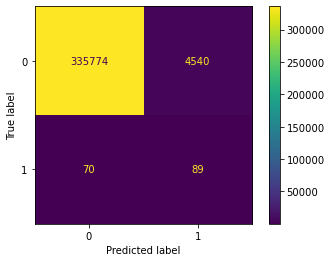

Accuracy Score:  0.9870386198024513
Precision Score:  0.017687074829931974
Recall Score:  0.49056603773584906
F1 Score:  0.03414313854235063
DecisionTreeClassifier(max_features=40, random_state=648061058)   0.9870386198024513


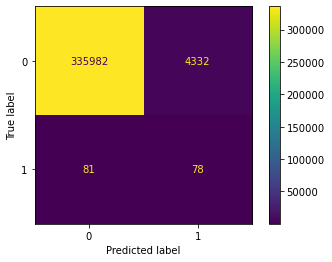

Accuracy Score:  0.9845626525451358
Precision Score:  0.017238113279030118
Recall Score:  0.5723270440251572
F1 Score:  0.03346818683339463
DecisionTreeClassifier(max_features=40, random_state=88409749)   0.9845626525451358


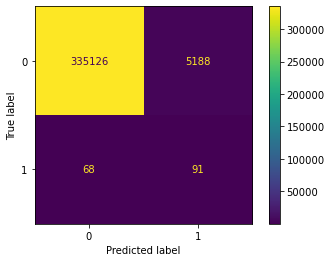

Accuracy Score:  0.9877024022462868
Precision Score:  0.021160247265810745
Recall Score:  0.559748427672956
F1 Score:  0.04077892325315005
DecisionTreeClassifier(max_features=40, random_state=242285876)   0.9877024022462868


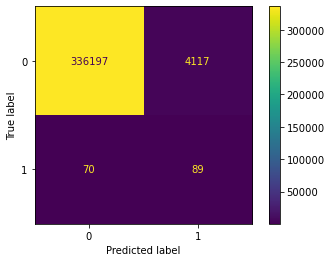

Accuracy Score:  0.9906453668866547
Precision Score:  0.025705329153605017
Recall Score:  0.5157232704402516
F1 Score:  0.04896984174380412
DecisionTreeClassifier(max_features=40, random_state=2018247425)   0.9906453668866547


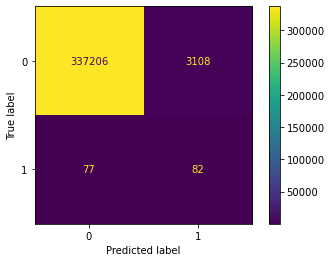

Accuracy Score:  0.9886598937360672
Precision Score:  0.023919753086419752
Recall Score:  0.5849056603773585
F1 Score:  0.045959970348406216
DecisionTreeClassifier(max_features=40, random_state=953477463)   0.9886598937360672


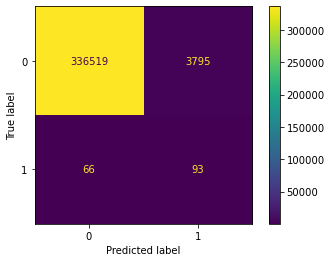

Accuracy Score:  0.9889712253247688
Precision Score:  0.023834745762711863
Recall Score:  0.5660377358490566
F1 Score:  0.045743329097839895
DecisionTreeClassifier(max_features=40, random_state=1427830251)   0.9889712253247688


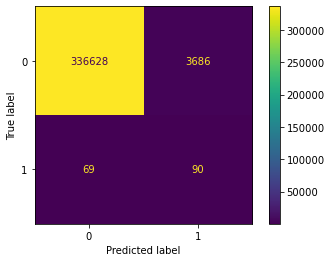

Accuracy Score:  0.9888008740781208
Precision Score:  0.022727272727272728
Recall Score:  0.5471698113207547
F1 Score:  0.0436418359668924
DecisionTreeClassifier(max_features=40, random_state=1883569565)   0.9888008740781208


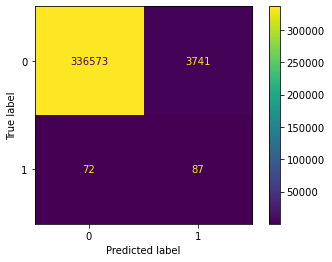

Accuracy Score:  0.984001668267381
Precision Score:  0.012177121771217712
Recall Score:  0.41509433962264153
F1 Score:  0.023660154149489153
DecisionTreeClassifier(max_features=40, random_state=911989541)   0.984001668267381


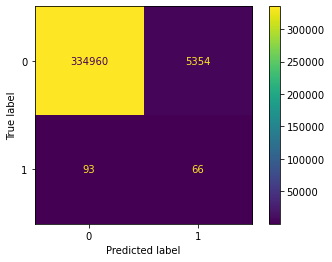

Accuracy Score:  0.9894646565219563
Precision Score:  0.02468108707709373
Recall Score:  0.559748427672956
F1 Score:  0.047277556440903055
DecisionTreeClassifier(max_features=40, random_state=3344769)   0.9894646565219563


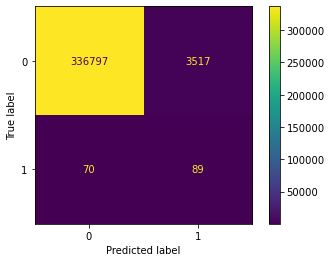

Accuracy Score:  0.9877347102413407
Precision Score:  0.021671826625386997
Recall Score:  0.5723270440251572
F1 Score:  0.041762276273519965
DecisionTreeClassifier(max_features=40, random_state=780932287)   0.9877347102413407


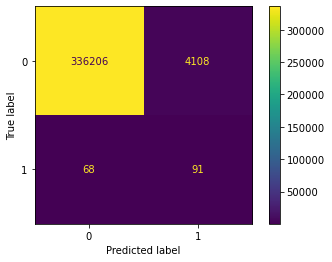

Accuracy Score:  0.9880401676491234
Precision Score:  0.021755072109508677
Recall Score:  0.559748427672956
F1 Score:  0.04188235294117647
DecisionTreeClassifier(max_features=40, random_state=2114032571)   0.9880401676491234


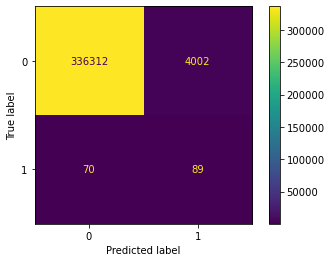

Accuracy Score:  0.9877905149600703
Precision Score:  0.020393474088291747
Recall Score:  0.5345911949685535
F1 Score:  0.03928819043217009
DecisionTreeClassifier(max_features=40, random_state=787716372)   0.9877905149600703


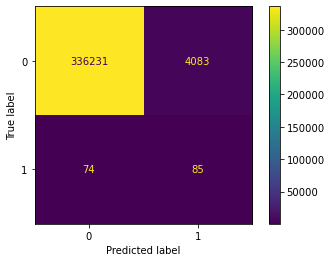

Accuracy Score:  0.9883309396046088
Precision Score:  0.02133534136546185
Recall Score:  0.5345911949685535
F1 Score:  0.041033067825247405
DecisionTreeClassifier(max_features=40, random_state=504579232)   0.9883309396046088


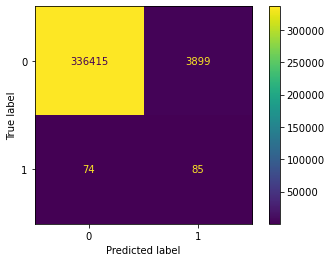

Accuracy Score:  0.9891327653000385
Precision Score:  0.02135712354690457
Recall Score:  0.4968553459119497
F1 Score:  0.04095386210471747
DecisionTreeClassifier(max_features=40, random_state=1306710475)   0.9891327653000385


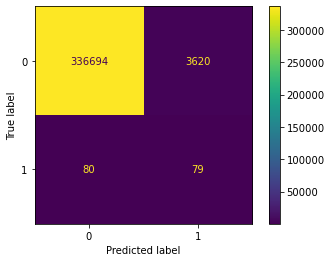

Accuracy Score:  0.9888860497014448
Precision Score:  0.01884788956729493
Recall Score:  0.44654088050314467
F1 Score:  0.03616912888436067
DecisionTreeClassifier(max_features=40, random_state=479546681)   0.9888860497014448


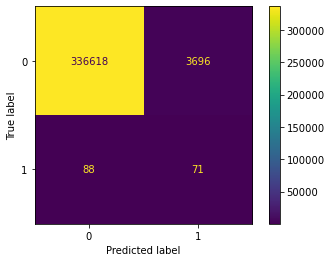

Accuracy Score:  0.9874498124667742
Precision Score:  0.01916783543712015
Recall Score:  0.5157232704402516
F1 Score:  0.03696191120126211
DecisionTreeClassifier(max_features=40, random_state=106328085)   0.9874498124667742


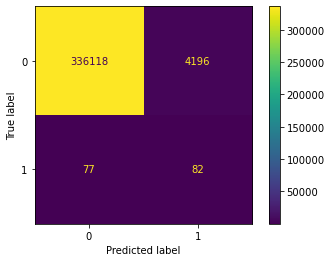

Accuracy Score:  0.9888654900682287
Precision Score:  0.02033808769149498
Recall Score:  0.48427672955974843
F1 Score:  0.039036755386565265
DecisionTreeClassifier(max_features=40, random_state=30349564)   0.9888654900682287


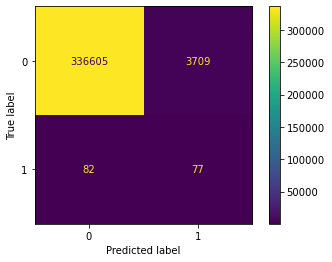

Accuracy Score:  0.9876789055226112
Precision Score:  0.020209224916785545
Recall Score:  0.5345911949685535
F1 Score:  0.038946162657502864
DecisionTreeClassifier(max_features=40, random_state=1855189739)   0.9876789055226112


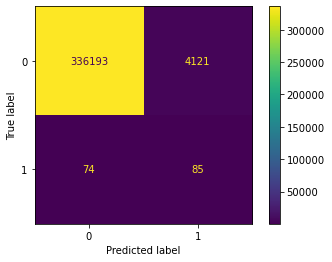

Accuracy Score:  0.9861428072123193
Precision Score:  0.018585005279831045
Recall Score:  0.5534591194968553
F1 Score:  0.035962402942378416
DecisionTreeClassifier(max_features=40, random_state=99052376)   0.9861428072123193


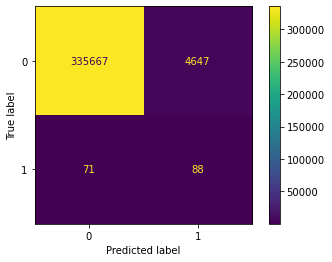

Accuracy Score:  0.9886363970123916
Precision Score:  0.020671834625323
Recall Score:  0.5031446540880503
F1 Score:  0.03971208736659221
DecisionTreeClassifier(max_features=40, random_state=1250819632)   0.9886363970123916


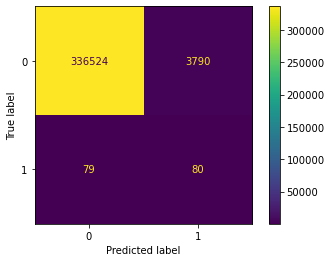

Accuracy Score:  0.9854937102207811
Precision Score:  0.015605999189298744
Recall Score:  0.48427672955974843
F1 Score:  0.03023758099352052
DecisionTreeClassifier(max_features=40, random_state=106406362)   0.9854937102207811


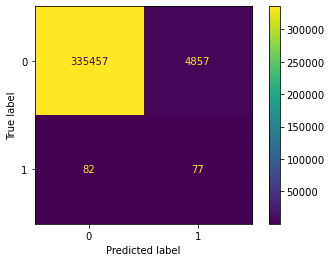

Accuracy Score:  0.9873470143006935
Precision Score:  0.021011313784345415
Recall Score:  0.5723270440251572
F1 Score:  0.04053452115812917
DecisionTreeClassifier(max_features=40, random_state=480404538)   0.9873470143006935


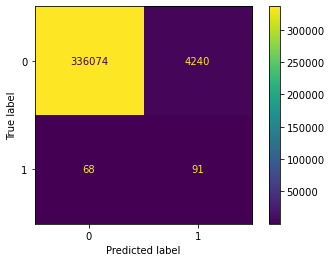

Accuracy Score:  0.9886892646406616
Precision Score:  0.02101712506486767
Recall Score:  0.5094339622641509
F1 Score:  0.04036880139546475
DecisionTreeClassifier(max_features=40, random_state=1717389822)   0.9886892646406616


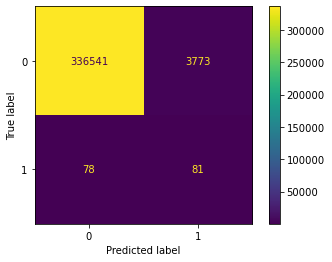

Accuracy Score:  0.9870768019784242
Precision Score:  0.021223752540076767
Recall Score:  0.5911949685534591
F1 Score:  0.040976460331299036
DecisionTreeClassifier(max_features=40, random_state=599121577)   0.9870768019784242


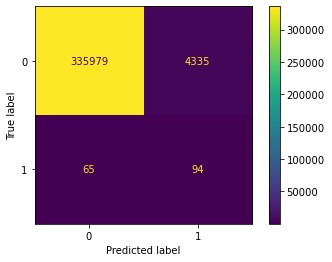

Accuracy Score:  0.9886540195551483
Precision Score:  0.024640657084188913
Recall Score:  0.6037735849056604
F1 Score:  0.04734895191122071
DecisionTreeClassifier(max_features=40, random_state=200427519)   0.9886540195551483


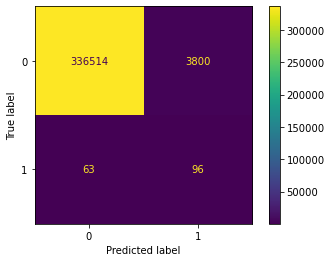

Accuracy Score:  0.9877552698745569
Precision Score:  0.01710019267822736
Recall Score:  0.44654088050314467
F1 Score:  0.0329389932730225
DecisionTreeClassifier(max_features=40, random_state=1254751707)   0.9877552698745569


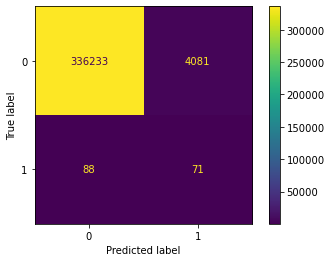

Accuracy Score:  0.9876201637134222
Precision Score:  0.019203413940256046
Recall Score:  0.5094339622641509
F1 Score:  0.037011651816312545
DecisionTreeClassifier(max_features=40, random_state=2034764475)   0.9876201637134222


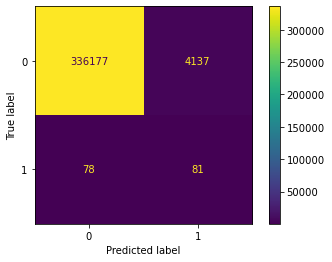

Accuracy Score:  0.989135702390498
Precision Score:  0.021621621621621623
Recall Score:  0.5031446540880503
F1 Score:  0.041461518528116095
DecisionTreeClassifier(max_features=40, random_state=1573512143)   0.989135702390498


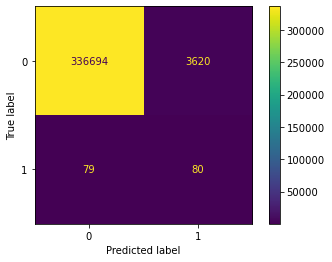

Accuracy Score:  0.9881928963530148
Precision Score:  0.020610876583064316
Recall Score:  0.5220125786163522
F1 Score:  0.03965599617773531
DecisionTreeClassifier(max_features=40, random_state=999745294)   0.9881928963530148


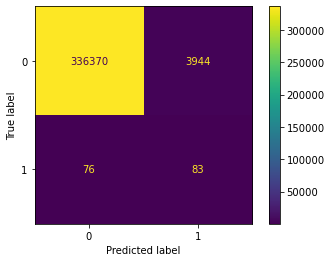

Accuracy Score:  0.9894059147127673
Precision Score:  0.024019878520154612
Recall Score:  0.5471698113207547
F1 Score:  0.04601957154192013
DecisionTreeClassifier(max_features=40, random_state=1958805693)   0.9894059147127673


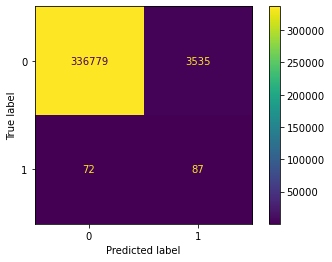

Accuracy Score:  0.9883720588710412
Precision Score:  0.019230769230769232
Recall Score:  0.4779874213836478
F1 Score:  0.0369739722695208
DecisionTreeClassifier(max_features=40, random_state=389151677)   0.9883720588710412


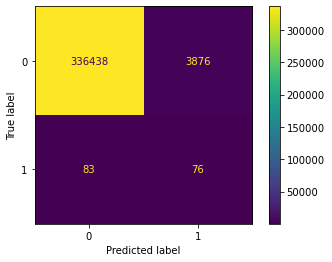

In [72]:
model_opt(clf, X_train_smote, y_train_smote, X_valid, y_valid)
plt.show()

In [73]:
ran_for.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [74]:
cost_benefit_analysis(ran_for, X_valid, y_valid)

-0.0024671559859372107